In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import xarray as xr

from utils import delayed_adstock
from plots import plot_posterior
from plots import plot_prior_predictive_samples
from models import mmm_model
from utils import max_abs_scaler
from utils import create_trend_seasonality


In [3]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.2.0


In [4]:
raw = pd.read_csv('../data/data.csv')
df=raw.copy()


In [5]:
spend_channels= ['spend_channel_1','spend_channel_2','spend_channel_3','spend_channel_4','spend_channel_5','spend_channel_6','spend_channel_7']
df['start_of_week'] = pd.to_datetime(df['start_of_week'],format="%d-%m-%y",dayfirst=True)
date_data= df['start_of_week']
channel_data = df[spend_channels]
target_data=df['revenue']
n_obs,n_channels= np.shape(channel_data)
df['day'] = df.start_of_week.dt.dayofyear


In [6]:
target_scaler, target_scaled = max_abs_scaler(target_data, True)
channel_scaler, channel_scaled = max_abs_scaler(channel_data,False)


<Axes: >

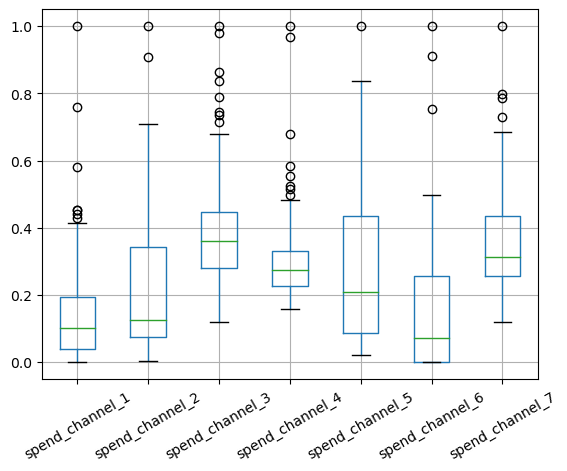

In [7]:
# outliers exist but the transformation is completed.
channel_scaled.boxplot( rot=30)

In [8]:
trend,seasonality = create_trend_seasonality(df)

In [23]:
model_input = {"date": date_data,
        "channel": channel_scaled,
        "seasonality":seasonality,
        "trend": trend
} 
target = target_scaled

In [24]:
model,model_prior_predictive = mmm_model(model_input,target,ll='Student')

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, nu, sigma]


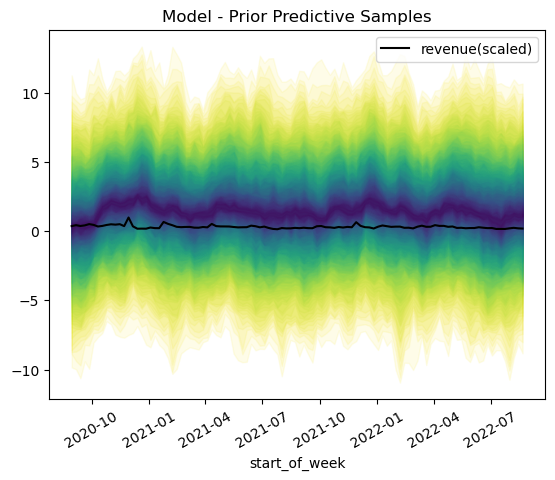

In [25]:
# useful way to color the distribution
plot_settings={
'palette' :"viridis_r",
'cmap' :plt.get_cmap("viridis_r"),
'percs' :np.linspace(51, 99, 100),
'colors' :(np.linspace(51, 99, 100) - np.min(np.linspace(51, 99, 100))) / (np.max(np.linspace(51, 99, 100)) - np.min(np.linspace(51, 99, 100)))}
plot_prior_predictive_samples(model_prior_predictive,target_scaled,date_data,plot_settings)


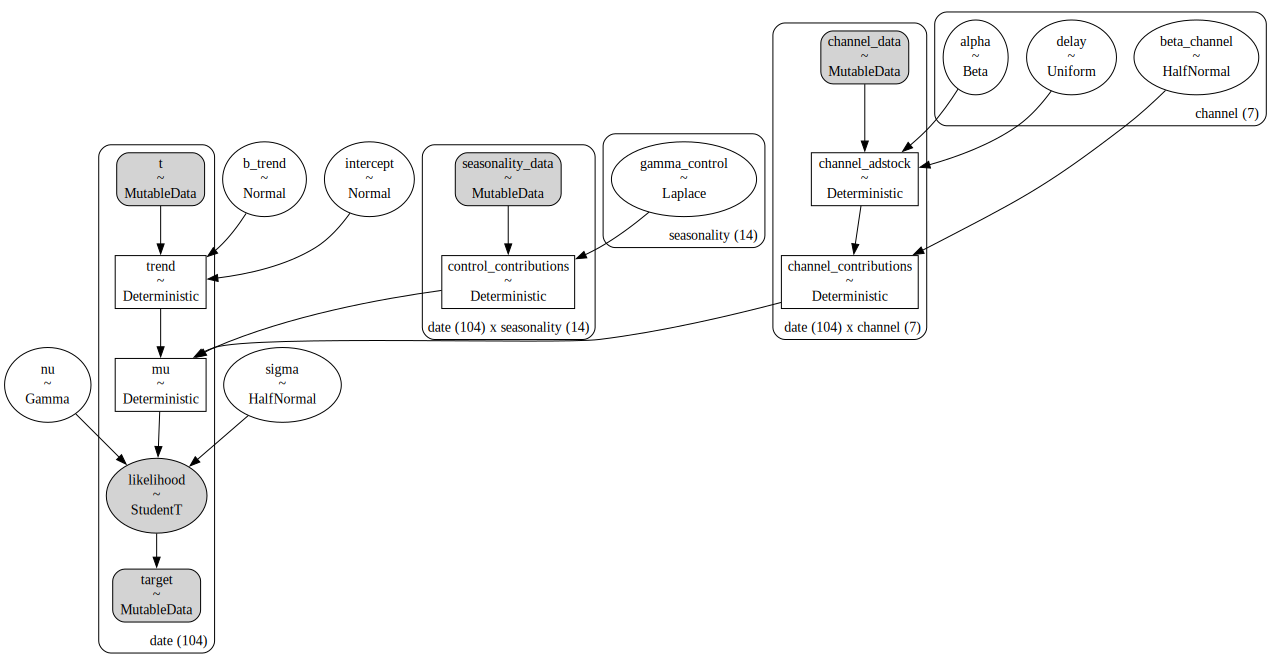

In [27]:
pm.model_to_graphviz(model=model)

In [13]:
with model:
    model_trace = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive = pm.sample_posterior_predictive(
        trace=model_trace
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:06.387951
Sampling...


Compiling.. :   0%|                                                                                                         | 0/9000 [00:00<?, ?it/s]

  0%|                                                                                                                       | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                                                         | 0/9000 [00:00<?, ?it/s]


  0%|                                                                                                                       | 0/9000 [00:00<?, ?it/s]


Running chain 1:   0%|                                                                                                      | 0/9000 [00:07<?, ?it/s]


Running chain 0:   0%|                                                                                                      | 0/9000 [00:07<?, ?it/s]

Running chain 0:   5%|████▌                                                                

Running chain 3:  80%|████████████████████████████████████████████████████████████████████████                  | 7200/9000 [00:44<00:08, 208.94it/s]

Running chain 0:  70%|██████████████████████████████████████████████████████████████▉                           | 6300/9000 [00:46<00:15, 172.54it/s]


Running chain 3:  85%|████████████████████████████████████████████████████████████████████████████▌             | 7650/9000 [00:46<00:06, 210.67it/s]

Running chain 1:  70%|██████████████████████████████████████████████████████████████▉                           | 6300/9000 [00:48<00:17, 154.94it/s]


Running chain 3:  90%|█████████████████████████████████████████████████████████████████████████████████         | 8100/9000 [00:49<00:04, 207.91it/s]

Running chain 0:  80%|████████████████████████████████████████████████████████████████████████                  | 7200/9000 [00:51<00:10, 170.19it/s]


Running chain 3:  95%|█████████████████████████████████████████████████████████████████████

Sampling time =  0:01:06.040227
Transforming variables...
Transformation time =  0:00:02.958655
Computing Log Likelihood...
Log Likelihood time =  0:00:02.509750


Sampling: [likelihood]


In [16]:
az.summary(
    data=model_trace,
    var_names=['alpha','delay','beta_channel'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
alpha[spend_channel_1]         0.476  0.192   0.133    0.829      0.001   
alpha[spend_channel_2]         0.596  0.188   0.256    0.926      0.001   
alpha[spend_channel_3]         0.443  0.170   0.126    0.755      0.001   
alpha[spend_channel_4]         0.513  0.191   0.159    0.851      0.001   
alpha[spend_channel_5]         0.499  0.188   0.159    0.840      0.001   
alpha[spend_channel_6]         0.551  0.173   0.233    0.858      0.001   
alpha[spend_channel_7]         0.501  0.182   0.180    0.844      0.001   
delay[spend_channel_1]         6.462  2.604   1.008   10.749      0.034   
delay[spend_channel_2]         3.656  2.310   0.001    8.424      0.030   
delay[spend_channel_3]         0.321  0.738   0.000    0.573      0.024   
delay[spend_channel_4]         4.803  3.258   0.000   10.234      0.029   
delay[spend_channel_5]         4.518  3.722   0.000   11.057      0.032   
delay[spend_channel_6]         1.350  0.684   0.160    2.245      0.007   
delay[spend_channel_7]         3.194  1.093   0.306    4.348      0.024   
beta_channel[spend_channel_1]  0.116  0.086   0.000    0.269      0.001   
beta_channel[spend_channel_2]  0.224  0.103   0.036    0.416      0.001   
beta_channel[spend_channel_3]  0.376  0.116   0.151    0.591      0.002   
beta_channel[spend_channel_4]  0.088  0.074   0.000    0.222      0.001   
beta_channel[spend_channel_5]  0.041  0.045   0.000    0.123      0.000   
beta_channel[spend_channel_6]  0.306  0.094   0.124    0.484      0.001   
beta_channel[spend_channel_7]  0.321  0.114   0.107    0.543      0.001   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha[spend_channel_1]           0.001   22234.0   20544.0    1.0  
alpha[spend_channel_2]           0.001   21650.0   22111.0    1.0  
alpha[spend_channel_3]           0.001   20828.0   17541.0    1.0  
alpha[spend_channel_4]           0.001   32923.0   21503.0    1.0  
alpha[spend_channel_5]           0.001   33177.0   20668.0    1.0  
alpha[spend_channel_6]           0.001   21054.0   19693.0    1.0  
alpha[spend_channel_7]           0.001   19031.0   16747.0    1.0  
delay[spend_channel_1]           0.024    8143.0   11902.0    1.0  
delay[spend_channel_2]           0.022    6112.0    9253.0    1.0  
delay[spend_channel_3]           0.017    4835.0    1759.0    1.0  
delay[spend_channel_4]           0.020   13169.0   17434.0    1.0  
delay[spend_channel_5]           0.022   16232.0   20272.0    1.0  
delay[spend_channel_6]           0.007   11968.0    9309.0    1.0  
delay[spend_channel_7]           0.017    3470.0    1369.0    1.0  
beta_channel[spend_channel_1]    0.001    7596.0   11183.0    1.0  
beta_channel[spend_channel_2]    0.001    8564.0   10870.0    1.0  
beta_channel[spend_channel_3]    0.001    3260.0    2687.0    1.0  
beta_channel[spend_channel_4]    0.000   12575.0   15122.0    1.0  
beta_channel[spend_channel_5]    0.000   14093.0   15192.0    1.0  
beta_channel[spend_channel_6]    0.001    4800.0    4274.0    1.0  
beta_channel[spend_channel_7]    0.001    7234.0    5183.0    1.0

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (21), generating only 20 plots
  warnings.warn(


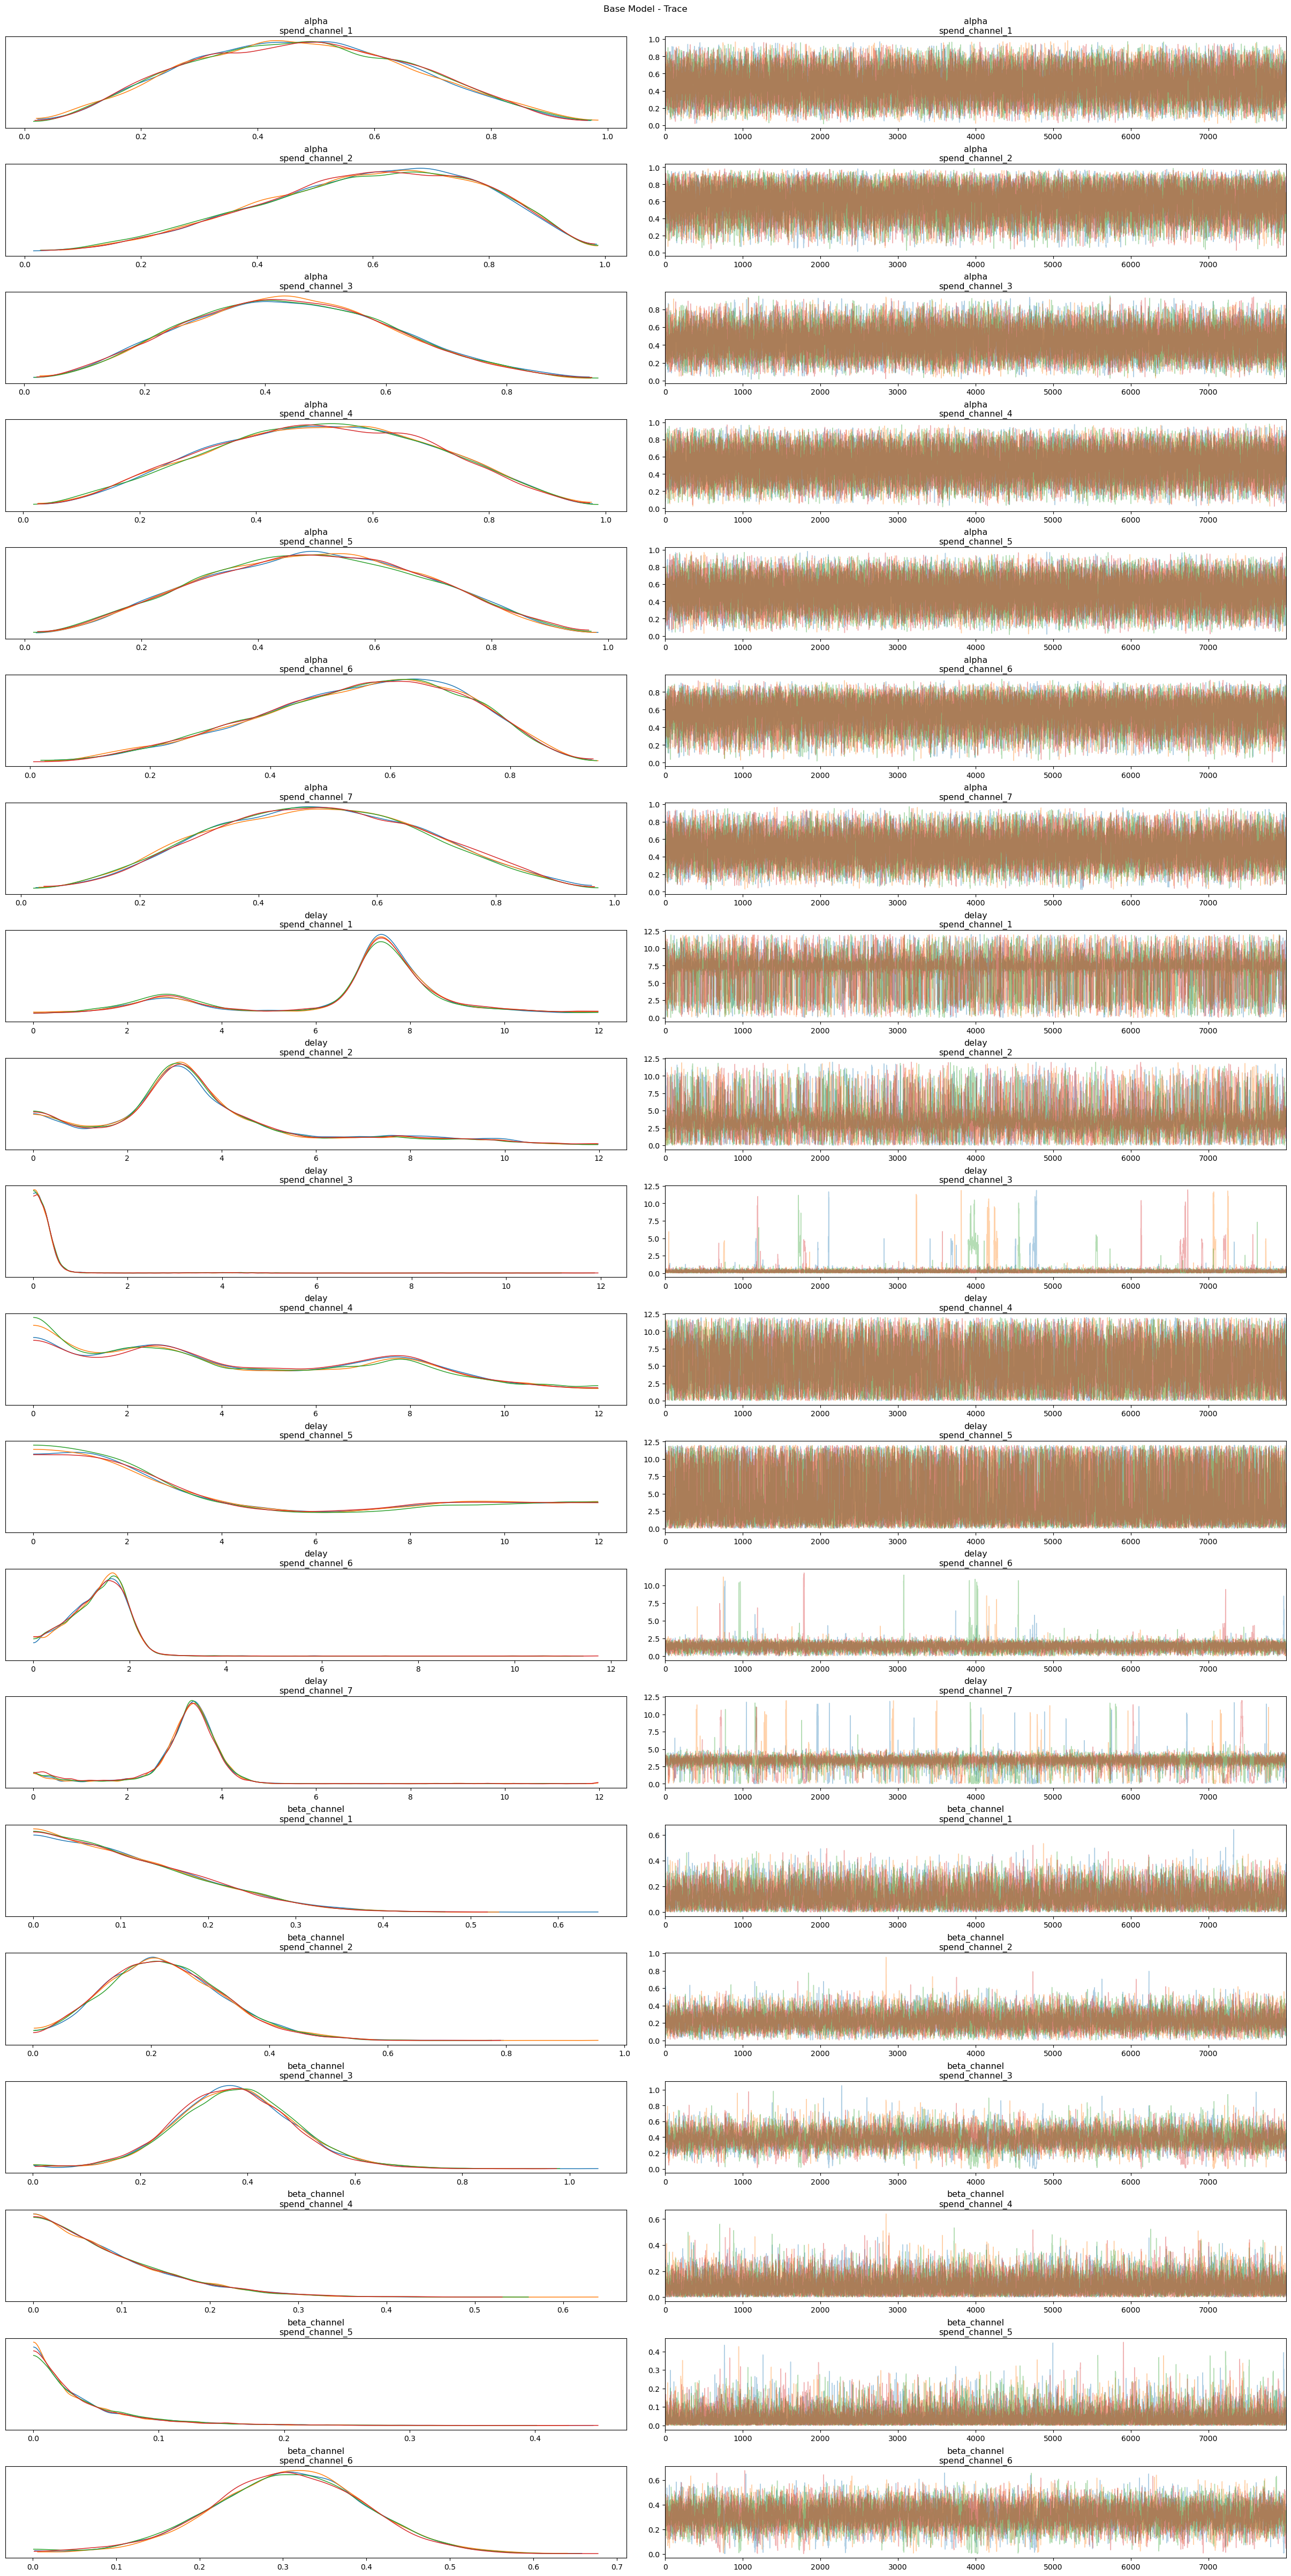

In [17]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['alpha','delay','beta_channel'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (24, 48),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()
# here we see on the right side distribtuion on each chain seperatly . on left we see the 
# convergence on each chain.

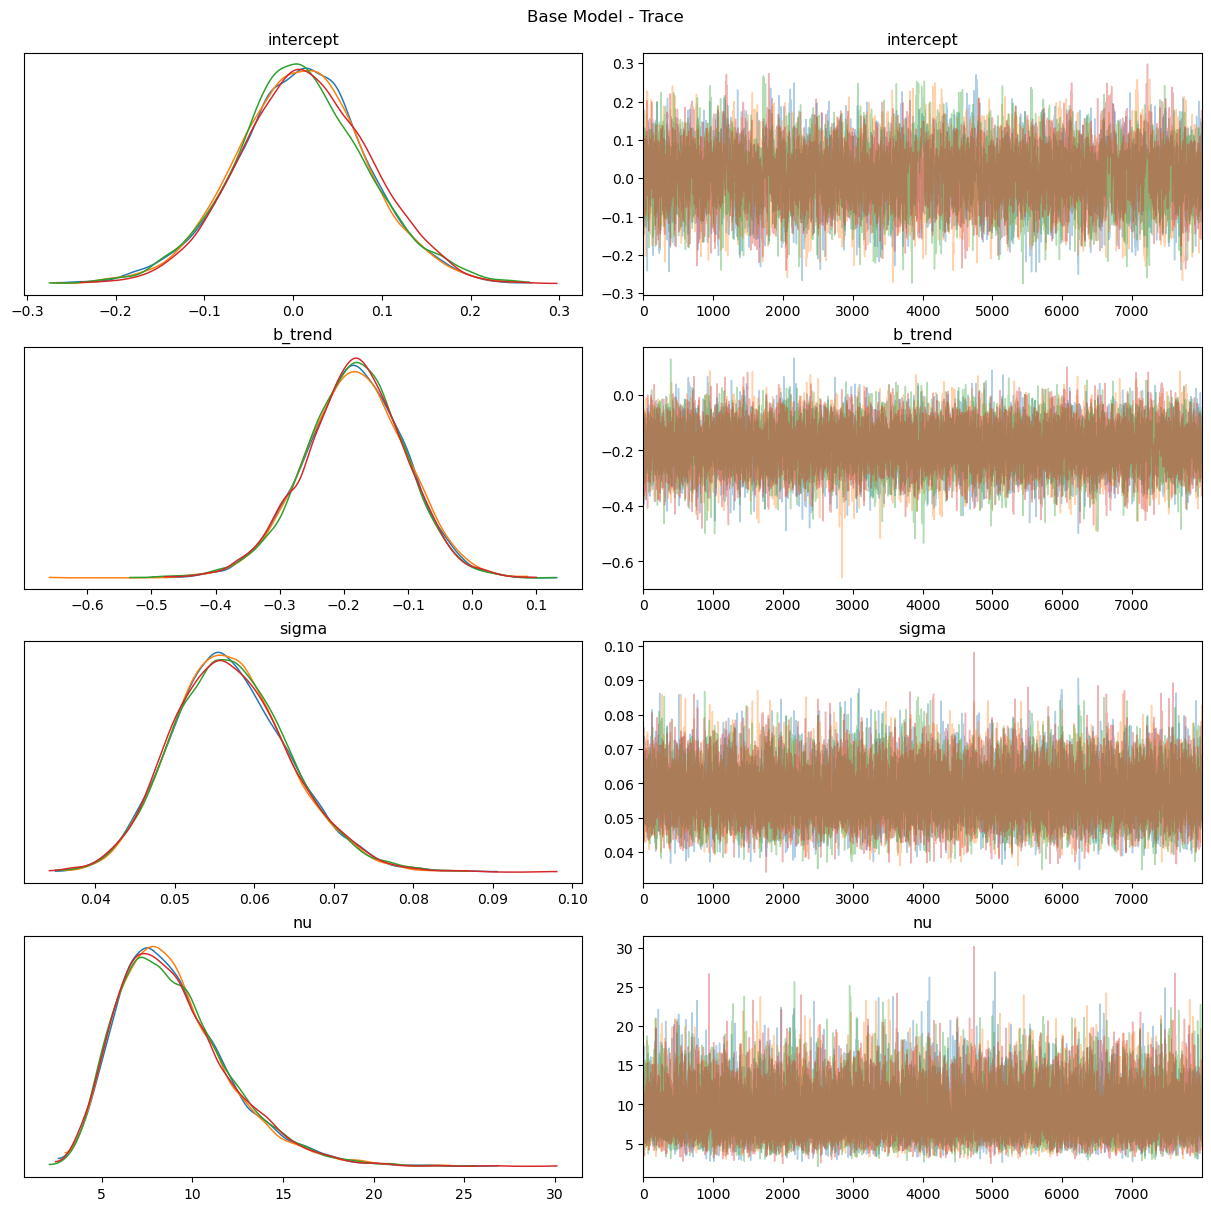

In [20]:
axes = az.plot_trace(
    data=model_trace,
#     var_names=['alpha','delay','intercept','b_trend','beta_channel','nu','gamma_control'],
    var_names=['intercept','b_trend','sigma','nu'],
    compact=False,
    combined=False,
    backend_kwargs={
        "figsize": (12, 12),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("Base Model - Trace")
plt.show()

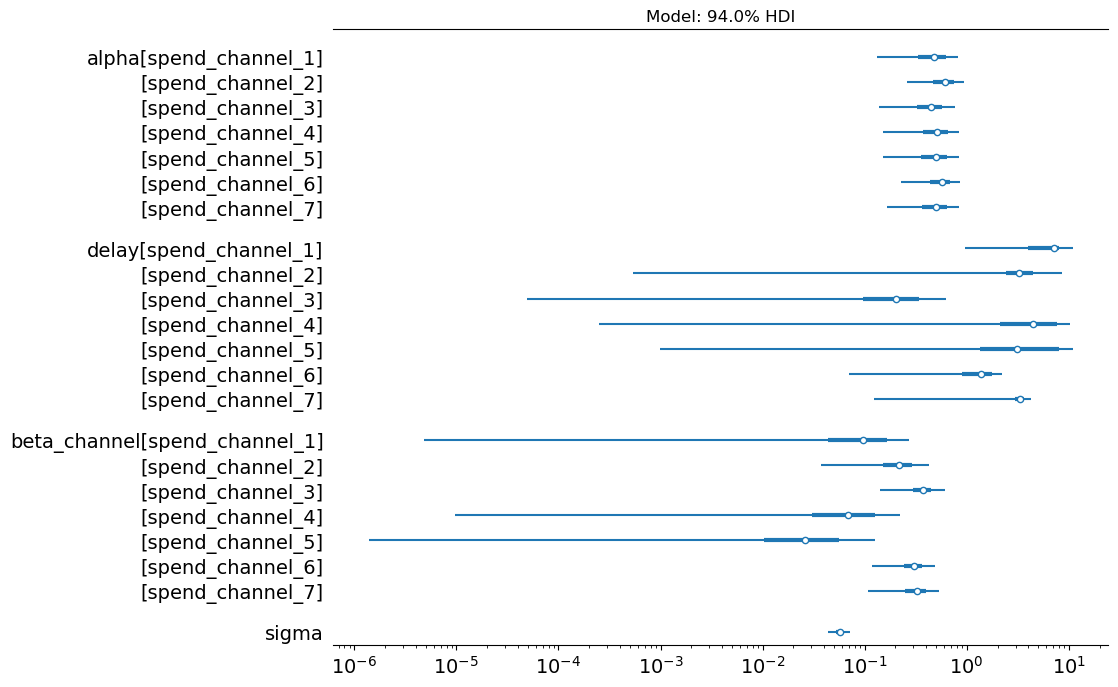

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    data=model_trace,
    var_names=['alpha','delay','beta_channel','sigma'],
    combined=True,
    ax=ax
)
ax.set(
    title="Model: 94.0% HDI",
    xscale="log"
)
plt.show()

In [ ]:
## posterior prediction

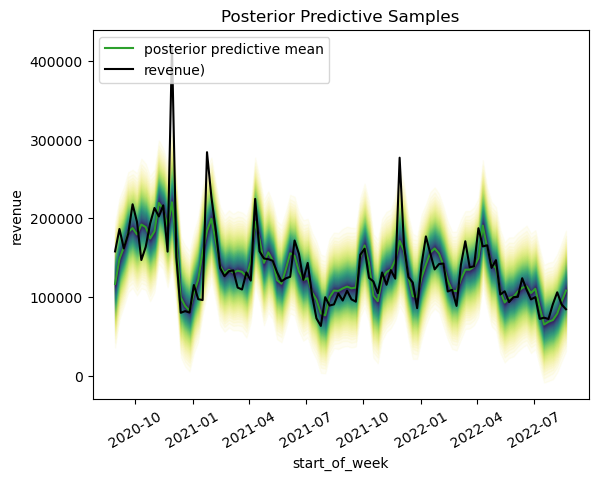

In [21]:
plot_posterior(model_posterior_predictive,date_data,target_data,target_scaler,plot_settings)


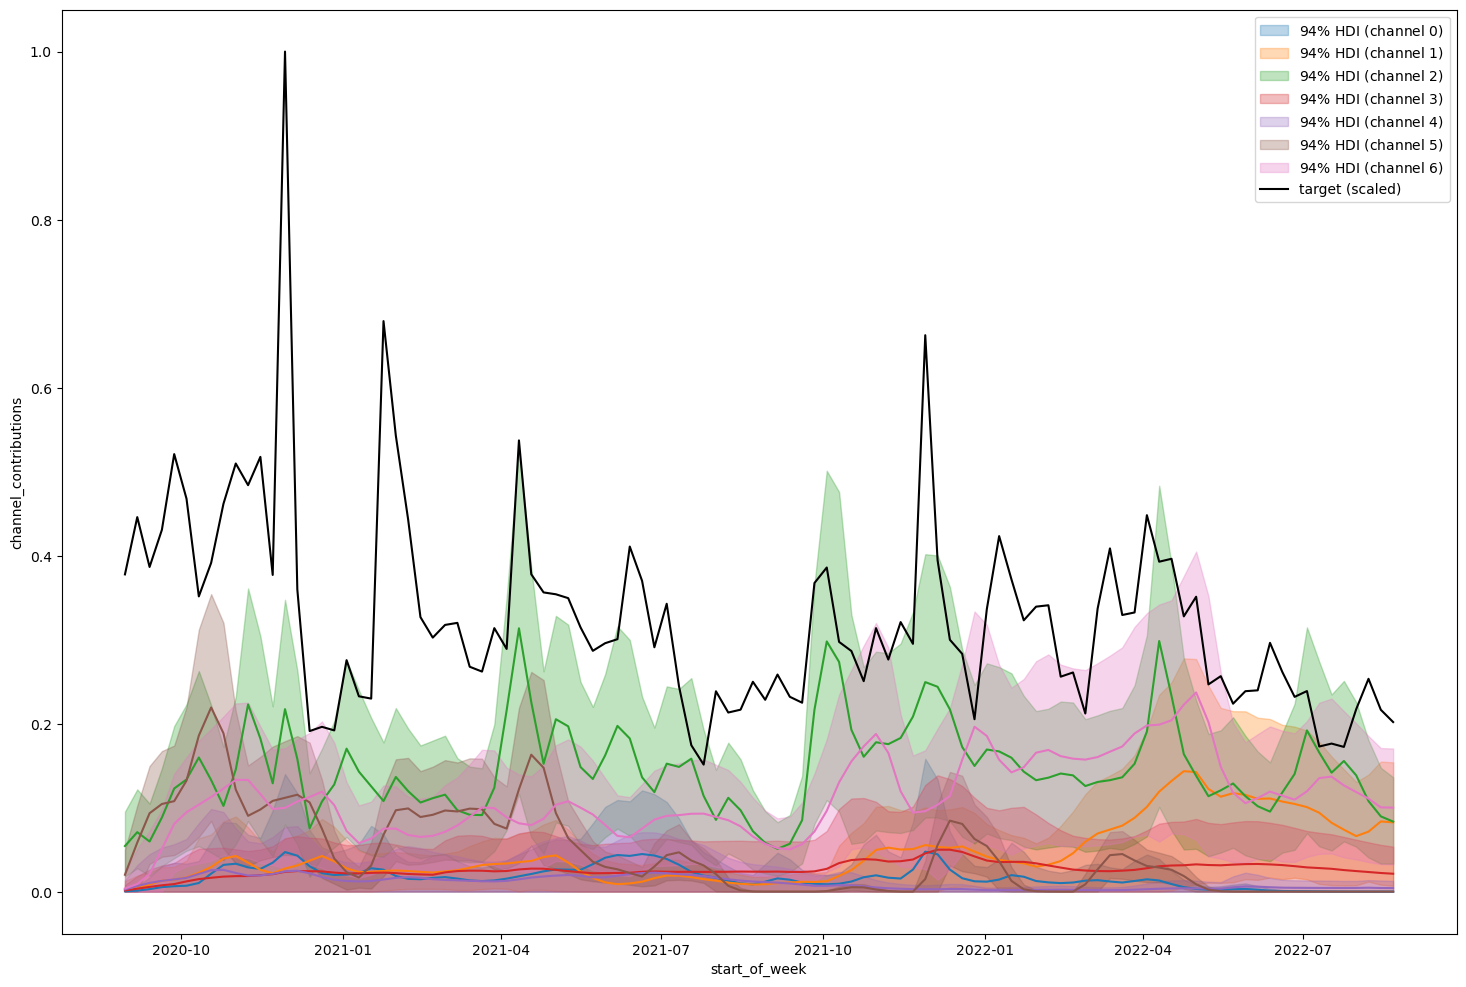

In [17]:
#The HDI can be used in the context of
#uncertainty characterisation of posterior distributions as Credible Interval (CI).
model_hdi = az.hdi(ary=model_trace)

fig, ax = plt.subplots(figsize=(18, 12))

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['channel_contributions'][:, i,0],
        y2=model_hdi['channel_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.3,
        label=f"$94\%$ HDI (channel {i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['channel_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=1.0, label="target (scaled)", ax=ax)
plt.show()

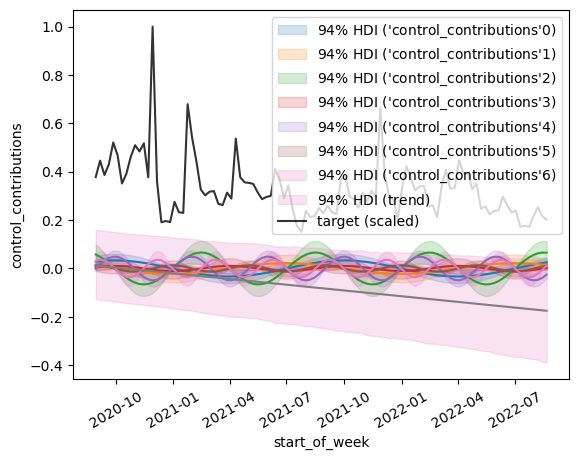

In [18]:
# compute HDI for all the control parameters
fig, ax = plt.subplots()

for i in range(n_channels):
    ax.fill_between(
        x=date_data,
        y1=model_hdi['control_contributions'][:, i,0],
        y2=model_hdi['control_contributions'][:, i,1],
        color=f"C{i}",
        alpha=0.2,
        label=f"$94\%$ HDI ('control_contributions'{i})",
    )
    sns.lineplot(
        x=date_data,
        y=model_trace.posterior['control_contributions'].stack(sample=("chain", "draw")).mean(axis=2)[:,i]
    )

ax.fill_between(
    x=date_data,
    y1=model_hdi['trend'][:,0],
    y2=model_hdi['trend'][:,1],
    color=f"C{i}",
    alpha=0.2,
    label=f"$94\%$ HDI ({'trend'})",
)
sns.lineplot(
    x=date_data,
    y=model_trace.posterior['trend'].stack(sample=("chain", "draw")).mean(axis=1)
)
sns.lineplot(x=date_data, y=target_scaled, color="black", alpha=0.8, label="target (scaled)", ax=ax)
plt.xticks(rotation=30)
plt.show()

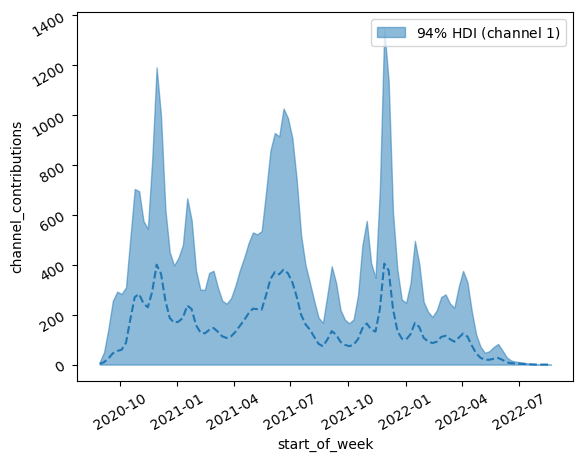

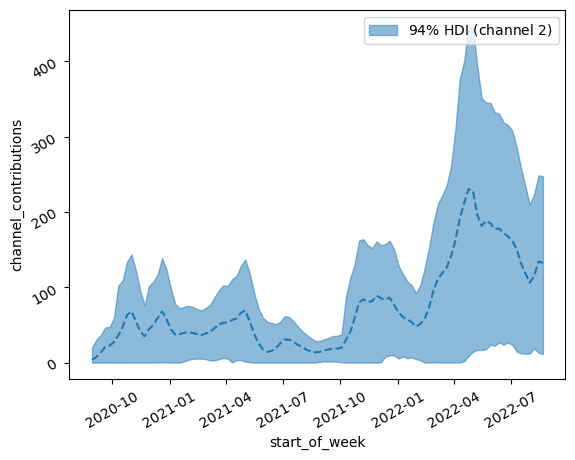

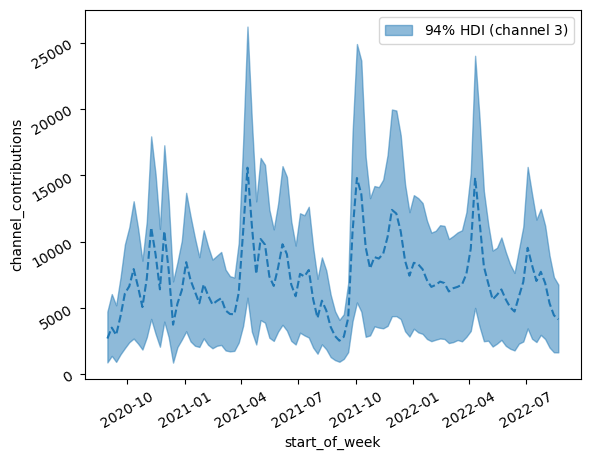

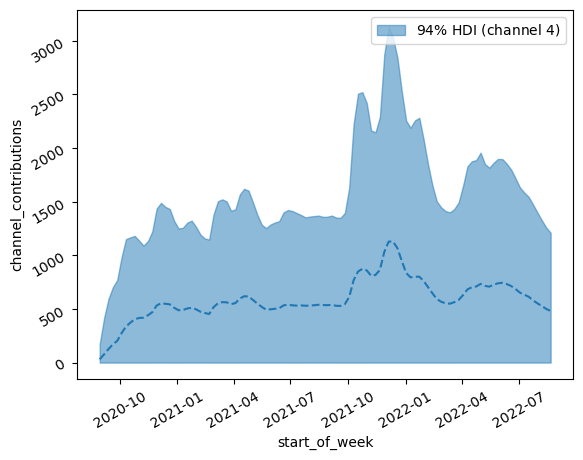

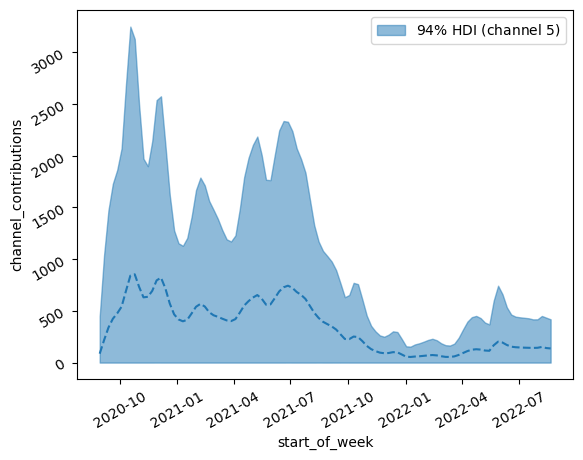

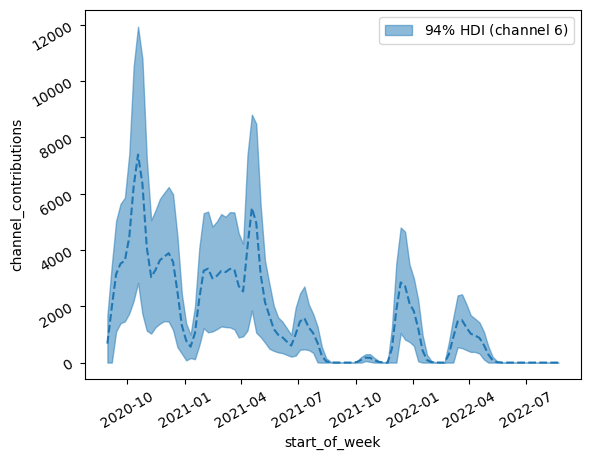

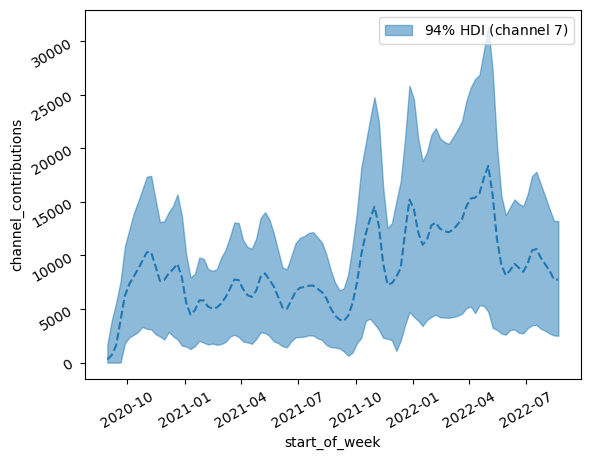

In [19]:
#channel contribtuion figures

channel_contributions_posterior_samples = xr.apply_ufunc(
    lambda x: channel_scaler.inverse_transform(X=x),
    model_trace.posterior["channel_contributions"],
    input_core_dims=[["date","channel"]],
    output_core_dims=[["date","channel"]],
    vectorize=True,
)


channel_effect_hdi = az.hdi(ary=channel_contributions_posterior_samples)["channel_contributions"]

for i in range(n_channels):

    fig, ax = plt.subplots()
    ax.fill_between(
        x=date_data,
        y1=channel_effect_hdi[:,i ,0],
        y2=channel_effect_hdi[:,i ,1],
        color="C0",
        alpha=0.5,
        label=f"$94\%$ HDI (channel {i+1})",
    )
    ax.tick_params(labelrotation=30)
    sns.lineplot(
        x=date_data,
        y=channel_contributions_posterior_samples.stack(sample=("chain", "draw")).mean(axis=2)[:,i],
        linestyle="--",
    )
ax.legend(loc="upper right")
plt.show()

In [22]:
model_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [28]:
model_normal,model_prior_predictive_normal =  mmm_model(model_input,target,ll='Normal')

Sampling: [alpha, b_trend, beta_channel, delay, gamma_control, intercept, likelihood, sigma]


In [29]:
model_normal

            intercept ~ N(0, 1)
              b_trend ~ N(0, 1)
         beta_channel ~ N**+(0, 1)
                alpha ~ Beta(3, 3)
                delay ~ U(0, 12)
                sigma ~ N**+(0, 1)
        gamma_control ~ Laplace(0, 1)
      channel_adstock ~ Deterministic(f(alpha, delay))
channel_contributions ~ Deterministic(f(beta_channel, alpha, delay))
                trend ~ Deterministic(f(intercept, b_trend))
control_contributions ~ Deterministic(f(gamma_control))
                   mu ~ Deterministic(f(intercept, b_trend, gamma_control, beta_channel, alpha, delay))
           likelihood ~ N(mu, sigma)

In [30]:
with model_normal:
    model_trace_normal = pm.sample(
        nuts_sampler="numpyro",
        draws=8_000,
        chains=4,
        idata_kwargs={"log_likelihood": True},
    )
    model_posterior_predictive_normal = pm.sample_posterior_predictive(
        trace=model_trace_normal
    )

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:05.112322
Sampling...


Compiling.. :   0%|                          | 0/9000 [00:00<?, ?it/s]

  0%|                                        | 0/9000 [00:00<?, ?it/s]

Compiling.. :   0%|                          | 0/9000 [00:00<?, ?it/s]


  0%|                                        | 0/9000 [00:00<?, ?it/s]


Running chain 1:   0%|                       | 0/9000 [00:05<?, ?it/s]


Running chain 0:   0%|                       | 0/9000 [00:05<?, ?it/s]

Running chain 0:   5%|▌           | 450/9000 [00:09<01:15, 113.78it/s]

Running chain 2:   5%|▌           | 450/9000 [00:09<01:15, 112.56it/s]


Running chain 1:  10%|█▏          | 900/9000 [00:10<00:42, 190.25it/s]

Running chain 0:  10%|█▏          | 900/9000 [00:10<00:44, 181.81it/s]


Running chain 0:  15%|█▋         | 1350/9000 [00:12<00:32, 233.58it/s]

Running chain 2:  15%|█▋         | 1350/9000 [00:12<00:33, 226.20it/s]


Running chain 0:  20%|██▏        | 1800/9000 [00:13<00:28, 256.12it/s]

Running chain 2:  20%|██▏        | 1800/9000 [00:13<00:28,

Sampling time =  0:00:46.827352
Transforming variables...
Transformation time =  0:00:02.316311
Computing Log Likelihood...
Log Likelihood time =  0:00:03.410338


Sampling: [likelihood]


In [31]:
dataset_dict = {
    "model": model_trace,
    "model_normal": model_trace_normal,
}
df_comp = az.compare(compare_dict=dataset_dict, ic="loo", method="stacking", scale="log")
df_comp

/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/shamecube/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


rank    elpd_loo      p_loo  elpd_diff    weight         se  \
model            0  112.481572  32.059435    0.00000  0.943868  14.700564   
model_normal     1   97.465953  33.227443   15.01562  0.056132  15.896163   

                   dse  warning scale  
model         0.000000    False   log  
model_normal  5.664699     True   log

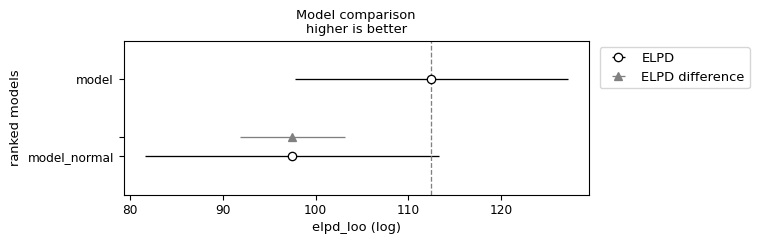

In [32]:
az.plot_compare(df_comp, insample_dev=False)
plt.show()

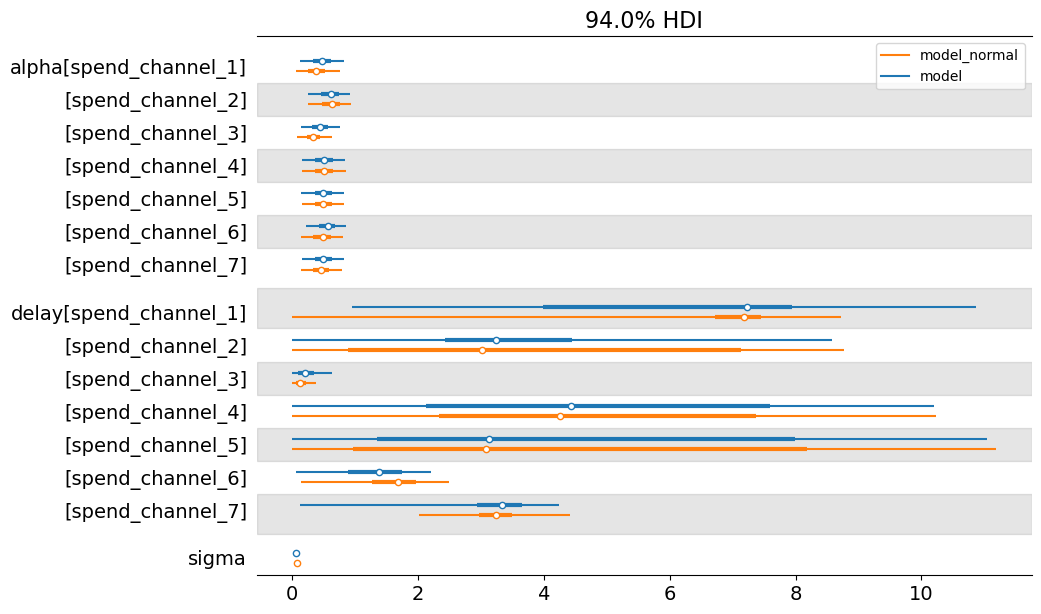

In [33]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['alpha','delay','sigma'],
    combined=True,
    figsize=(10, 7),
)
plt.show()

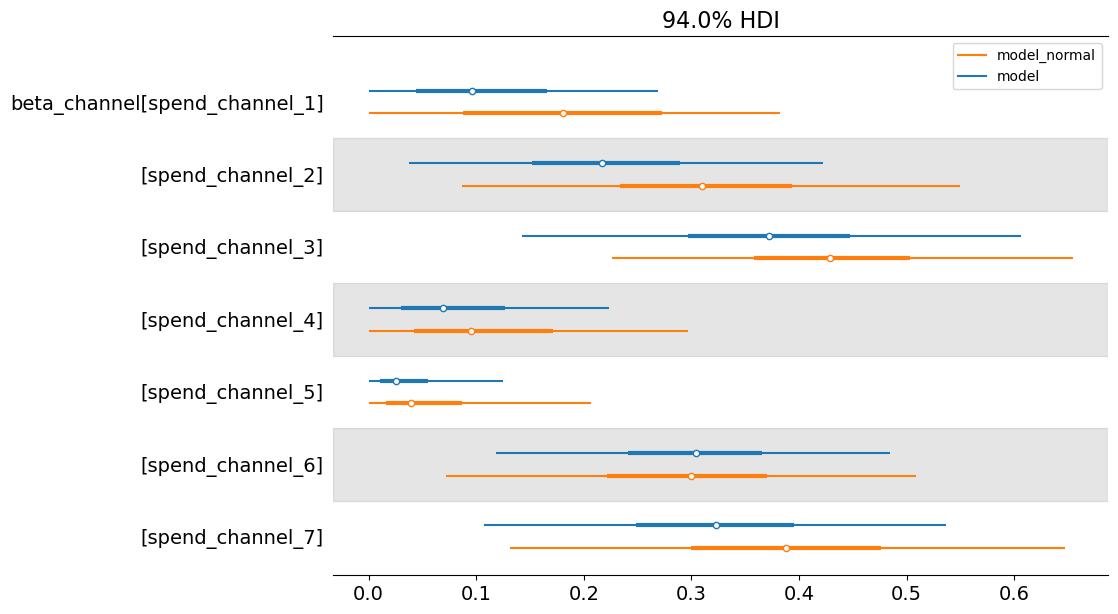

In [34]:
axes = az.plot_forest(
    data=[model_trace, model_trace_normal],
    model_names=["model", "model_normal"],
    var_names=['beta_channel'],
    combined=True,
    figsize=(10, 7),
)
plt.show()